# Speech Emotion Classification

###### Major Obstacles source: 
- Emotions are subjective, people would interpret it differently. It is hard to define the notion of emotions.
- Annotating an audio recording is challenging. Should we label a single word, sentence or a whole conversation? How many emotions should we define to recognize?
- Collecting data is complex. There are lots of audio data can be achieved from films or news. However, both of them are biased since news reporting has to be neutral and actors’ emotions are imitated. It is hard to look for neutral audio recording without any bias.
- Labeling data require high human and time cost. Unlike drawing a bounding box on an image, it requires trained personnel to listen to the whole audio recording, analysis it and give an annotation. The annotation result has to be evaluated by multiple individuals due to its subjectivity.
- Converting the speech data into text would also result in loss in emotion information.
These obstacles make SER very challenging though in this we have tried to recognize the emotion from speech.


In [42]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 0. Dependencies

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import shutil
import pickle

In [0]:
import numpy as np
import torch
import pandas as pd

In [32]:
import keras
import fastai

Using TensorFlow backend.


In [0]:
from pathlib import Path

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# to play the sound
import IPython.display as ipd

In [0]:
import librosa
import librosa.display

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
# progress bar
from tqdm import tqdm

## 1. Data Collection

#### Dataset source: https://github.com/SenticNet/MELD

In [0]:
# !unzip drive/My\ Drive/emotion
# !unzip drive/My\ Drive/speech-features

## Data Exploration

In [0]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [0]:
t_path = Path('meld/train/')
v_path = Path('meld/val/')

In [0]:
classes = os.listdir('meld/train/')
train_samples = []
val_samples = []
for c in classes:
  train_samples.append(len(os.listdir('meld/train/'+c)))
  val_samples.append(len(os.listdir('meld/val/'+c)))

In [42]:
classes

['happy', 'neutral', 'disgust', 'fear', 'sad']

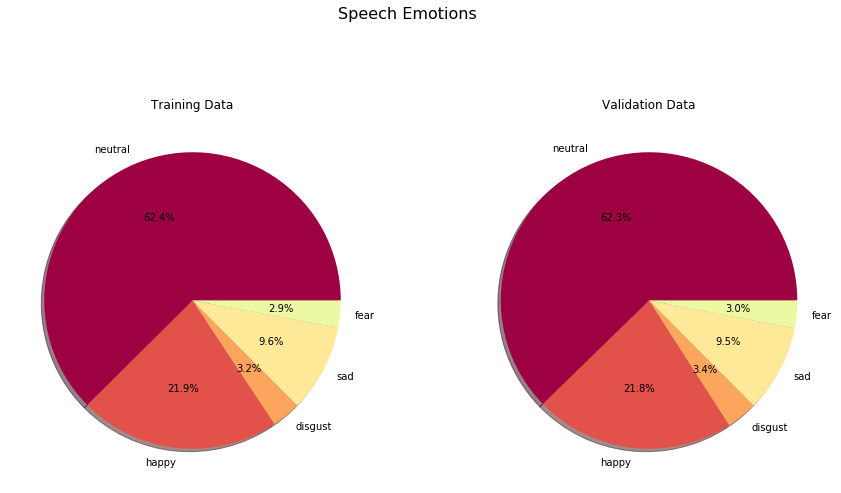

In [0]:
# Make square figures and axes
plt.figure(1, figsize=(15,15))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


plt.subplot(the_grid[0, 0], aspect=1, title='Training Data')
train_pie = plt.pie(train_samples, labels=classes, autopct='%.1f%%', shadow=True, colors=colors)

plt.subplot(the_grid[0, 1], aspect=1, title='Validation Data')
val_pie = plt.pie(val_samples,labels=classes, autopct='%.1f%%', shadow=True, colors=colors)


plt.suptitle('Speech Emotions', fontsize=16)


plt.show()


##### From the above plot we can say that data is imbalanced




In [43]:
print(classes)
print(train_samples)
print(val_samples)

['happy', 'neutral', 'disgust', 'fear', 'sad']
[1609, 4592, 232, 216, 705]
[181, 517, 28, 25, 79]


In [44]:
sum(val_samples)

830

# 1. Speech Emotion Recognition using Librosa Spectral Features

## 1.1 Features Extraction and Data Preprocessing 

###### we will extract three features from the input audion files

In [0]:
y, sr = librosa.load('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav',)

In [0]:
librosa.feature.melspectrogram(y=y, sr=sr,  ).shape

(128, 173)

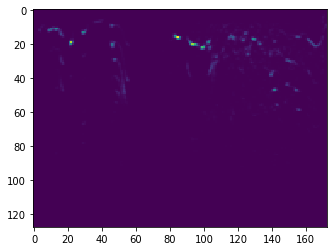

In [0]:
plt.imshow(mel)

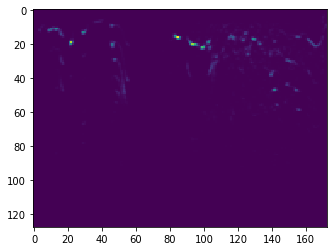

In [0]:
plt.imshow(librosa.feature.melspectrogram(y=y, sr=sr))

In [0]:
classes

['neutral', 'happy', 'disgust', 'sad', 'fear']

In [0]:
l = os.listdir(t_path/np.random.choice(classes))

In [0]:
# type(S_dB)

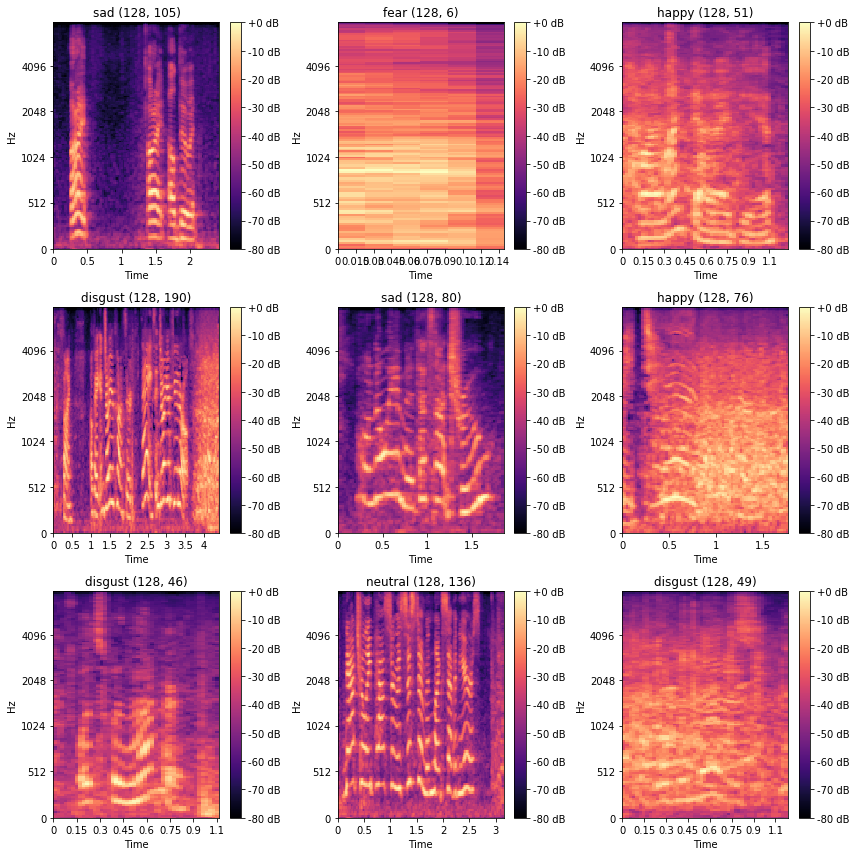

In [0]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    c = np.random.choice(classes)
    file = np.random.choice(os.listdir(t_path/c))
    fig.add_subplot(rows, columns, i)
    
    y, sr = librosa.load(t_path/c/file)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(c+" " + str(S_dB.shape))
    plt.tight_layout()
plt.show()

#### We will use following features from input audio speech:
- mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
- chroma: Pertains to the 12 different pitch classes
- mel: Mel Spectrogram Frequency

In [0]:
classes = sorted(classes)
cls_to_idx = dict(zip(classes, np.linspace(0, 4, 5, dtype=np.int8)))
idx_to_cls = dict(zip(np.linspace(0, 4, 5, dtype=np.int8), classes))

In [46]:
cls_to_idx

{'disgust': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}

In [47]:
idx_to_cls

{0: 'disgust', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad'}

In [0]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file, mfcc, chroma, mel):
  
  #print(file)

  result=np.array([])

  y, sr = librosa.load(file)

  if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis = 0)
      result=np.hstack((result, mfccs))
  if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
      result=np.hstack((result, chroma))
#       print('error-1')
  if mel:
#       print(type(librosa.feature.melspectrogram(y=y, sr=sr)))
      mel= np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T,axis=0)
#       print('error-2')
      result=np.hstack((result, mel))
      
  return result

In [0]:
#DataFlair - Load the data and extract features for each sound file
def load_data(path):
  
    x,y, files =[],[], []
    
    for cls in classes:
      i = 0
      for file in os.listdir(path/cls):
        emotion = cls
#         print(emotion)
        feature = extract_feature(path/cls/file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
        files.append(file)
        
        if i%500==0:
          print('{} of class '.format(i)+cls+' have been processed')
        i+=1
        
    return x, y, files

In [135]:
x_train, y_train, train_files = load_data(t_path)

0 of class disgust have been processed
0 of class fear have been processed
0 of class happy have been processed
500 of class happy have been processed
1000 of class happy have been processed
1500 of class happy have been processed
0 of class neutral have been processed
500 of class neutral have been processed
1000 of class neutral have been processed
1500 of class neutral have been processed
2000 of class neutral have been processed
2500 of class neutral have been processed
3000 of class neutral have been processed
3500 of class neutral have been processed
4000 of class neutral have been processed
4500 of class neutral have been processed
0 of class sad have been processed
500 of class sad have been processed


In [137]:
x_test, y_test, test_files = load_data(v_path)

0 of class disgust have been processed
0 of class fear have been processed
0 of class happy have been processed
0 of class neutral have been processed
500 of class neutral have been processed
0 of class sad have been processed


In [0]:
actual_x_train, actual_y_train, actual_train_files = x_train, y_train, train_files
actual_x_test, actual_y_test, actual_test_files = x_test, y_test, test_files

In [139]:
# validate the features
# number of samples in train and val data should be equal to len of feature
print(sum(train_samples), sum(val_samples))
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

7354 830
7354 830
7354 830


In [0]:
train_features = np.array(x_train)
train_labels = np.array(y_train)
test_features = np.array(x_test)
test_labels = np.array(y_test)

In [141]:
print(train_features.shape, test_features.shape)
print(train_labels.shape, test_labels.shape)

(7354, 160) (830, 160)
(7354,) (830,)


In [0]:
x_train = train_features
x_test = test_features
y_train = train_labels
y_test = test_labels

In [0]:
from sklearn.utils import shuffle

In [0]:
x_train, y_train, train_files = shuffle(actual_x_train, actual_y_train, train_files)
x_test, y_test, test_files = shuffle(actual_x_test, actual_y_test, test_files)

In [144]:
print(train_features.shape, test_features.shape)
print(train_labels.shape, test_labels.shape)

(7354, 160) (830, 160)
(7354,) (830,)


In [0]:
# save these features into local machine we might need it later
os.mkdir('meld_features/')

In [0]:
with open('meld_features/train_features.pkl', 'wb') as fp:
  pickle.dump(train_features, fp)
with open('meld_features/test_features.pkl', 'wb') as fp:
  pickle.dump(test_features, fp)
with open('meld_features/train_labels.pkl', 'wb') as fp:
  pickle.dump(train_labels, fp)
with open('meld_features/test_labels.pkl', 'wb') as fp:
  pickle.dump(test_labels, fp)
with open('meld_features/targets.pkl', 'wb') as fp:
  pickle.dump(classes, fp)
with open('meld_features/cls_to_idx.pkl', 'wb') as fp:
  pickle.dump(cls_to_idx, fp)
with open('meld_features/idx_to_cls.pkl', 'wb') as fp:
  pickle.dump(idx_to_cls, fp)


In [0]:
# zip the directory to download it
# !zip -r meld_features.zip meld_features/

  adding: meld_features/ (stored 0%)
  adding: meld_features/test_labels.pkl (deflated 99%)
  adding: meld_features/idx_to_cls.pkl (deflated 18%)
  adding: meld_features/test_features.pkl (deflated 4%)
  adding: meld_features/train_labels.pkl (deflated 100%)
  adding: meld_features/cls_to_idx.pkl (deflated 17%)
  adding: meld_features/targets.pkl (deflated 7%)
  adding: meld_features/train_features.pkl (deflated 4%)


In [0]:
y_train = [cls_to_idx[cls] for cls in y_train]
y_test = [cls_to_idx[cls] for cls in y_test]

## 1.2 Classification Models

In [0]:
from google.colab import files
uploaded = files.upload()

Saving plot_confusion_matrix.py to plot_confusion_matrix.py


In [0]:
from plot_confusion_matrix import plot_confusion_matrix

### 1.2.1 Support Vector Machine Classifier

In [0]:
from sklearn.svm import SVC

In [0]:
svm = SVC()

In [0]:
svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
svm_train_p = model.predict(x_train)

In [0]:
svm_test_p = model.predict(x_test)

In [0]:
print('training accuracy = {}'.format(accuracy_score(y_true=y_train, y_pred=svm_train_p)))
print('training accuracy = {}'.format(accuracy_score(y_true=y_test, y_pred=svm_test_p)))

training accuracy = 0.6373402230078868
training accuracy = 0.6240963855421687


In [0]:
actual_labels = []

In [0]:
# plot_confusion_matrix(y_true=y_train, y_pred=svm_train_p, classes=np.array(classes), title='train_pred')

In [0]:
# plot_confusion_matrix(y_true=y_test, y_pred=svm_test_p, classes=np.array(classes), title='train_pred')

### 1.2.2 Deep Neural Network Classifier

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
model = MLPClassifier(alpha=0.2, activation='relu', shuffle=True,  batch_size=512, epsilon=1e-08, hidden_layer_sizes=(1000,), learning_rate='adaptive', max_iter=1000, )

In [153]:
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.2, batch_size=512, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
# hidden layers = 300
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6520261082404134


In [0]:
# hidden layers = 500
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6525700299156921
val_acc = 0.6048192771084338


In [0]:
# hidden layers = 700
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6362523796573294
val_acc = 0.6180722891566265


In [154]:
# hidden layers = 1000 with tanh activation
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.638156105520805
val_acc = 0.6204819277108434


In [0]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [156]:
# hidden layers = 1000 with relu activation
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=train_pred)))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=test_pred)))

training_acc = 0.638156105520805
val_acc = 0.6204819277108434


In [157]:
type(train_pred)

numpy.ndarray

In [0]:
predictions = {}

for i in range(test_pred.shape[0]):
  data = {}
  data['actual'] = y_test[i]
  data['predicted']=test_pred[i]
  predictions[test_files[i]]=data

In [159]:
len(predictions)

830

In [86]:
idx_to_cls

{0: 'disgust', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad'}

In [0]:
correct = 0
for i in range(len(y_test)):
  if y_test[i]==test_pred[i]:
    correct+=1

In [92]:
correct/len(y_test)

0.6120481927710844

In [0]:
with open('actual.pkl', 'wb') as fp:
  pickle.dump(y_test, fp)
  
with open('predicted.pkl', 'wb') as fp:
  pickle.dump(test_pred, fp)
    

Confusion matrix, without normalization
[[   6    0    2  224    0]
 [   1    2    6  207    0]
 [   0    0   97 1512    0]
 [   0    0   12 4580    0]
 [   1    0    6  696    2]]


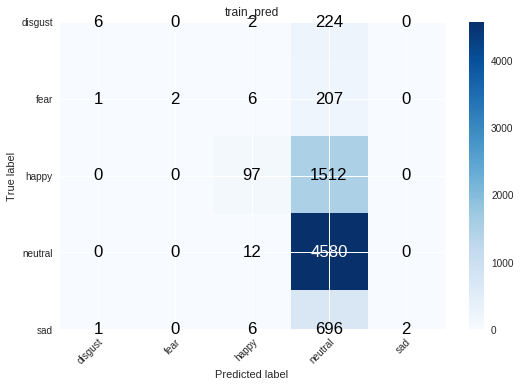

In [0]:
plt.style.use('seaborn')
plot_confusion_matrix(y_true=y_train, y_pred=train_pred, classes=np.array(classes), title='train_pred')

Confusion matrix, without normalization
[[  0   0   1  27   0]
 [  0   0   2  23   0]
 [  0   0   3 178   0]
 [  0   0   2 515   0]
 [  1   0   3  75   0]]


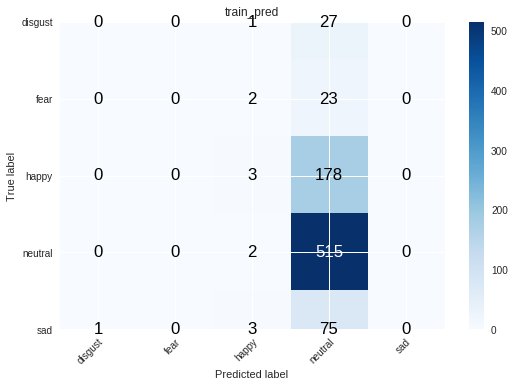

In [0]:
plot_confusion_matrix(y_true=y_test, y_pred=test_pred, classes=np.array(classes), title='train_pred')

### 1.2.3 Classification using Convolutional(1D Conv) Neural Networks 

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
# one hot vector notation of the target values
y_train_cat = keras.utils.np_utils.to_categorical(y_train, num_classes=5)
y_test_cat = keras.utils.np_utils.to_categorical(y_test, num_classes=5)

In [0]:
# we have to rehsape the train and test data as well
x_train_ = x_train.reshape(-1, x_train.shape[1], 1)
x_test_ = x_test.reshape(-1, x_test.shape[1], 1)

In [0]:
# check the shape of the training and validation data
print(x_train_.shape, y_train_cat.shape)
print(x_test_.shape, y_test_cat.shape)

(7354, 160, 1) (7354, 5)
(830, 160, 1) (830, 5)


In [0]:
# checkpoints
es = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, verbose=1)
mcp = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)

In [0]:
# model architecutre
model = Sequential()
model.add(Conv1D(filters=62, kernel_size=2, activation='relu', input_shape=(160, 1)))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=6, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=7, activation='relu'))
model.add(Conv1D(filters=12, kernel_size=11, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=13, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=13, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=17, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=23, activation='relu'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))


In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 159, 62)           186       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 156, 32)           7968      
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 151, 32)           6176      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 145, 16)           3600      
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 135, 12)           2124      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 123, 24)           3768      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 111, 24)         

In [0]:
# compile the model
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(x_train_, y_train_cat, batch_size=256, epochs=100, validation_data=(x_test_, y_test_cat), callbacks=[es, mcp])

Train on 7354 samples, validate on 830 samples
Epoch 1/100
7354/7354 [==============================] - 2s 288us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00001: val_acc did not improve from 0.62289
Epoch 2/100
7354/7354 [==============================] - 1s 111us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00002: val_acc did not improve from 0.62289
Epoch 3/100
7354/7354 [==============================] - 1s 114us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00003: val_acc did not improve from 0.62289
Epoch 4/100
7354/7354 [==============================] - 1s 112us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00004: val_acc did not improve from 0.62289
Epoch 5/100
7354/7354 [==============================] - 1s 114us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00005: val_acc did not improve from 0.62289
Epoch 6/100
7

In [0]:
preds = model.predict(x_test_)

In [0]:
preds[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

# **2. Speech Emotion Classification using Textual Features**

###### So far we have used 3 different models(SVM, ANN, CNN(1D Conv)) but all the three models gave ~60% accuracy and all are extremely biased towards Neutral class, primarily this is because of;
- Data Imabalance
- Incorrect Features

###### In order to overcome this we will extract different features(text features) and downsample the dataset







## 2.1 Textual Feature Extraction (Speech to text generation)

In [0]:
# !sudo apt-get install -qq python python-dev python-pip build-essential swig libpulse-dev
# !sudo pip install pocketsphinx

In [162]:
!pip install SpeechRecognition
import speech_recognition as sr

     |████████████████████████████████| 32.8MB 312kB/s 


In [0]:
r = sr.Recognizer()

In [0]:
file = 'meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav'
file_audio = sr.AudioFile(file)
ipd.Audio(file)

In [0]:
with file_audio as source:
  audio = r.record(source)

In [0]:
r.recognize_sphinx(audio)

'would you look at the dock at at at hit a'

In [0]:
a = r.recognize_google(audio)

In [0]:
a

'would you look at this dump'

In [166]:
!curl -X POST -u "apikey:IUsZZBiWve_v7Jd0fGezFwNzODFnNKhZZ9FdhY-GPnZR" \
--header "Content-Type: audio/wav" \
--data-binary @meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav \
"https://gateway-lon.watsonplatform.net/speech-to-text/api/v1/recognize?max_alternatives=3"


{
   "results": [
      {
         "alternatives": [
            {
               "confidence": 0.66, 
               "transcript": "would you look at this and don "
            }, 
            {
               "transcript": "would you look at this and dot "
            }, 
            {
               "transcript": "would you look at this dot "
            }
         ], 
         "final": true
      }
   ], 
   "result_index": 0
}

In [167]:
!pip install --upgrade "ibm-watson>=4.0.1"

     |████████████████████████████████| 307kB 6.4MB/s 
     |████████████████████████████████| 204kB 42.3MB/s 
  Created wheel for ibm-watson: filename=ibm_watson-4.0.1-cp36-none-any.whl size=296379 sha256=5b109cf08133075faae4f7fee40fd4dd104457cf047a0bd131433b2e962b9199
  Stored in directory: /root/.cache/pip/wheels/40/73/8a/809e738908cd1b0d34a383219c49ede9f9fba487584ad3377f
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-1.0.0-cp36-none-any.whl size=36085 sha256=be5f860640d1e014afb543b608a06b3f9205f30aba2c40db62fc3c604d47f870
  Stored in directory: /root/.cache/pip/wheels/12/e5/b5/90c69cc81edf5b95cbec373c83c3530266fdae8266037380df
Successfully built ibm-watson ibm-cloud-sdk-core


In [0]:
import json
from os.path import join, dirname
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [0]:
authenticator = IAMAuthenticator('IUsZZBiWve_v7Jd0fGezFwNzODFnNKhZZ9FdhY-GPnZR')
speech_to_text = SpeechToTextV1(authenticator=authenticator)

speech_to_text.set_service_url('https://gateway-lon.watsonplatform.net/speech-to-text/api')


with open('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav', 'rb') as audio_file:
    speech_recognition_results = speech_to_text.recognize(audio=audio_file, content_type='audio/wav',word_alternatives_threshold=0.9, timestamps=False).get_result()


In [170]:
speech_recognition_results['results'][0]['alternatives'][0]['transcript']

'would you look at this and don '

In [0]:
classes = os.listdir('meld/train/')

In [172]:
classes

['happy', 'neutral', 'disgust', 'fear', 'sad']

In [0]:
def extract_text_feature(file):
  text = ''
  file_audio = sr.AudioFile(file)
  with file_audio as source:
    audio = r.record(source)
    
  try:
    text = r.recognize_google(audio)
  except Exception:
    with open(file, 'rb') as audio_file:
      speech_recognition_results = speech_to_text.recognize(audio=audio_file, content_type='audio/wav',word_alternatives_threshold=0.9, timestamps=False).get_result()
      if len(speech_recognition_results['results']) > 0:
        text = speech_recognition_results['results'][0]['alternatives'][0]['transcript']
  except Exception:
    text = r.recognize_sphinx(audio) 
  except:
    text = 'no text recognized'
 
  return text

In [0]:
features = {}

In [0]:
#Load the data and extract features for each sound file

def load_data(path):
  
  classes = os.listdir(path)
  
  
  for cls in classes:
    
    i=0

    files = np.array(os.listdir(path+'/'+cls))
    
    # downsampling: we will take only 500 data points
    if files.shape[0] > 500:
      files = files[:500]

    for file in files:
      data = {}

      file_path = path+'/'+cls+'/'+file

      text = extract_text_feature(file_path)

      data['text']=text
      data['emotion']=cls

      features[file] = data


      if i%200==0:
        print("{} of class ".format(i)+cls+" have been processed")
      i+=1

  return features

In [185]:
val_features = load_data('meld/val')

0 of class happy have been processed
0 of class neutral have been processed
200 of class neutral have been processed
400 of class neutral have been processed
0 of class disgust have been processed
0 of class fear have been processed
0 of class sad have been processed


In [196]:
train_features = load_data('meld/train')

0 of class happy have been processed
200 of class happy have been processed
400 of class happy have been processed
0 of class neutral have been processed
200 of class neutral have been processed
400 of class neutral have been processed
0 of class disgust have been processed
200 of class disgust have been processed
0 of class fear have been processed
200 of class fear have been processed
0 of class sad have been processed
200 of class sad have been processed
400 of class sad have been processed


In [198]:
print(len(val_features), len(train_features))

830 1948


In [0]:
# val_features

In [0]:
# extract the data from the val_features dictionary
val_files = list(val_features.keys())
val_text = [val_features[key]['text'] for key in val_features.keys()]
val_emotion = [val_features[key]['emotion'] for key in val_features.keys()]

In [205]:
print(len(val_files), len(val_text), len(val_emotion))

830 830 830


In [0]:
# extract the data from the train_features dictionary
train_files = list(train_features.keys())
train_text = [train_features[key]['text'] for key in train_features.keys()]
train_emotion = [train_features[key]['emotion'] for key in train_features.keys()]

In [206]:
print(len(train_files), len(train_text), len(train_emotion))

1948 1948 1948


In [0]:
val_d = {'audio_files': val_files, 'text': val_text, 'emotion':val_emotion}
train_d = {'audio_files': train_files, 'text': train_text, 'emotion':train_emotion}

In [0]:
# make datafram from dictionary
val_df = pd.DataFrame(data=val_d)
train_df = pd.DataFrame(data=train_d)

In [211]:
val_df.head(3)

,audio_files,text,emotion
0,MEL_dia30_utt9_positive_HAP.wav,okay,happy
1,MEL_dia54_utt17_positive_HAP.wav,of course is going to have a good Joey,happy
2,MEL_dia2_utt8_positive_HAP.wav,you can do it,happy


In [213]:
train_df.head(3)

,audio_files,text,emotion
0,MEL_dia747_utt11_positive_HAP.wav,what is it that my given out some kind of a,happy
1,MEL_dia847_utt0_positive_HAP.wav,oh that is so sweet,happy
2,MEL_dia614_utt14_positive_HAP.wav,so we can help each other,happy


## 2.2 Text(Text of the Speech) Clasification using BERT 

In [0]:
# !pip install ktrain

In [215]:
import ktrain
from ktrain import text
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

using Keras version: 2.2.5


In [0]:
train_df = shuffle(train_df)
val_df = shuffle(val_df)

In [0]:
lb = LabelEncoder()

In [0]:
train_df['emotion_code'] = lb.fit_transform(train_df.emotion)
val_df['emotion_code'] = lb.transform(val_df.emotion)

In [228]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train_df, text_column='text', label_columns=['emotion_code'], val_df=val_df, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [229]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [0]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

In [231]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1948/1948 [==============================] - 409s 210ms/step - loss: 1.6477 - acc: 0.2074
Epoch 2/1024
1948/1948 [==============================] - 396s 203ms/step - loss: 1.5185 - acc: 0.3239
Epoch 3/1024
1948/1948 [==============================] - 394s 202ms/step - loss: 1.6406 - acc: 0.2849
Epoch 4/1024
1500/1948 [======================>.......] - ETA: 1:30 - loss: 3.4023 - acc: 0.2453

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


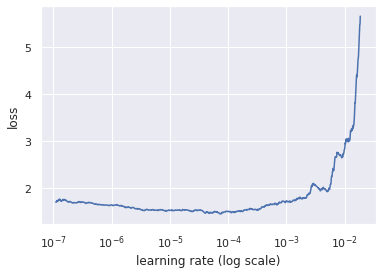

In [232]:
learner.lr_plot()

In [1]:
learner.fit_onecycle(lr=1e-5 , epochs=5)

NameError: ignored

In [239]:
1e-06

1e-06

###  emotion of an utterance in a conversation depends upon the following;
1. the speaker.

2. the context given by the preceding utterances.

3. the emotion behind the preceding utterances.

4. Pitch, Freq and Power of the utternce

In [0]:
import pickle

In [0]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving lb.pkl to lb.pkl


In [0]:
with open('true.pkl', 'rb') as fp:
  y_true = pickle.load(fp)
with open('predict.pkl', 'rb') as fp:
  y_pred = pickle.load(fp)
with open('lb.pkl', 'rb') as fp:
  targets = pickle.load(fp)

In [0]:
#from plot_confusion_matrix import plot_confusion_matrix

Confusion matrix, without normalization


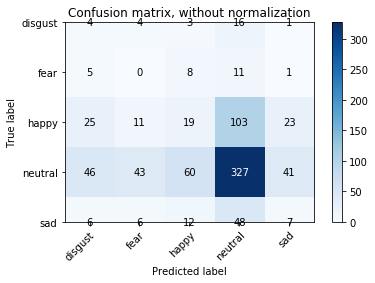

In [0]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred, classes=targets)

# **3. Multimodal Architecture for Speech Emotional Recognition**



### Why Multimodal Architecture ?
#### Emotion of the speech depends on more than one feature such as:
- Accoustic and Spectral Features
- Content (Textual Features)
- Prosodic Features, etc.
#### thats why we need a multimodal architecture that deals with the different features of the speech 


###### We have extracted the following features from the speech
- Mel Spectrogram
- MFCC
- RMS Energy
- Text Data
##### Mel Spectrogram and MFCC are images (specshow) we will feed this to CNN while RMS Energy is rank-1 tensor so we will feed it to Multilayer Perceptron MLP or Deep Neural Network(DNN), textual data will be passed through LSTM(Long Short Term Memory) network



## 3.1 Feature Extraction
- following libraries were used to extract the forementioned features 
- I have written the  following functions to extract the different features though since the data is bit large and it was taking time we have used multiple notebook to parallely extracting the features.

In [0]:
# # install the libraries and env dependencies
# !sudo apt-get install -qq python python-dev python-pip build-essential swig libpulse-dev
# !sudo pip install pocketsphinx
# !pip install --upgrade "ibm-watson>=4.0.1"
# !pip install SpeechRecognition

In [0]:
import speech_recognition as sr
import json
from os.path import join, dirname
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [0]:
r = sr.Recognizer()

In [0]:
file = 'meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav'
file_audio = sr.AudioFile(file)
ipd.Audio(file)

In [0]:
# recognition using google api
with file_audio as source:
  audio = r.record(source)
r.recognize_google(audio)

'would you look at this dump'

In [0]:
# recognition using IBM cloud speech to text
authenticator = IAMAuthenticator('IUsZZBiWve_v7Jd0fGezFwNzODFnNKhZZ9FdhY-GPnZR')
speech_to_text = SpeechToTextV1(authenticator=authenticator)

speech_to_text.set_service_url('https://gateway-lon.watsonplatform.net/speech-to-text/api')

In [0]:
with open('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav', 'rb') as audio_file:
    speech_recognition_results = speech_to_text.recognize(audio=audio_file, content_type='audio/wav',word_alternatives_threshold=0.9, timestamps=False).get_result()


In [0]:
speech_recognition_results['results'][0]['alternatives'][0]['transcript']

'would you look at this and don '

In [0]:
# quite close still google_api works bit better

In [0]:
def extract_text_feature(file):
  text = ''
  file_audio = sr.AudioFile(file)
  with file_audio as source:
    audio = r.record(source)
    
  try:
    text = r.recognize_google(audio)
  except Exception:
    with open(file, 'rb') as audio_file:
      speech_recognition_results = speech_to_text.recognize(audio=audio_file, content_type='audio/wav',word_alternatives_threshold=0.9, timestamps=False).get_result()
      if len(speech_recognition_results['results']) > 0:
        text = speech_recognition_results['results'][0]['alternatives'][0]['transcript']
  except Exception:
    text = r.recognize_sphinx(audio) 
  except:
    pass
  if len(text) < 1:
    text = 'no text recognized'
 
  return text

def get_mfcc(file, feature='mfcc'):
  
  # image file
  img = file.replace('.wav', '_mfcc.jpg')
  img = img.split('/')[-1]
  
  # mfcc features
  aud, sr = librosa.load(path=file, duration=6)
  mfcc = librosa.feature.mfcc(y=aud, sr=sr, n_mfcc=40)
  fig = librosa.display.specshow(mfcc, x_axis=None, y_axis=None)
  plt.box(on=False)
  plt.savefig('val_mel_spectrogram//'+img,  pad_inches=0)
  return img

  
def get_mel(file, feature='mel_spec'):
  
  # image file
  img = file.replace('.wav', '_mel.jpg')
  img = img.split('/')[-1]
  
  # get the mel spectrogram
  aud, sr = librosa.load(path=file, duration=6)
  S = librosa.feature.melspectrogram(y=aud, sr=sr, n_mels=128, fmax=8000)
  S_dB = librosa.power_to_db(S, ref=np.max)
  fig = librosa.display.specshow(S_dB, x_axis=None,y_axis=None, sr=sr, fmax=8000)
  
  plt.box(on=False)
  plt.savefig('val_mfcc/'+img,  pad_inches=0)
  
  return img

def get_rms(file, feature='rms'):
  aud, sr = librosa.load(path=file, duration=6)
  S, phase = librosa.magphase(librosa.stft(aud))
  rms = librosa.feature.rms(S=S)
  rms = rms.flatten()
  if rms.shape[0] < 128:
    rms = np.pad(rms, pad_width=128-rms.shape[0],mode='mean')
  elif rms.shape[0] > 128:
    rms = rms[:128]
  return rms

In [0]:
np.random.seed(42)

#DataFlair - Load the data and extract features for each sound file


def load_data(path):
  
    
  for cls in classes:
    
    i = 0
  
    files = np.array(os.listdir(path+'/'+cls))
    # downsampling we will take only less than 700(only for training data) data points
    if files.shape[0] > 700:
      files = files[np.random.permutation(1000)]
      
    for file in files:
      data = {}
      
      file_path = path+'/'+cls+'/'+file
      
      mfcc = get_mfcc(file_path)
      mel = get_mel(file_path)
      rms = get_rms(file_path)
      text = extract_text_feature(file_path)
      
      data['emotion']=cls
      data['mfcc']=mfcc
      data['mel']=mel
      data['rms']=rms
      data['text']=text
      
      val_features[file] = data

      
      if i%100==0:
        print('%d of class '%i+cls+" have been processed")
      i+=1
      

  return val_features


In [0]:
features = load_data('meld/val')

## 3.2 Data Preprocessing and Pipeline

###### As mentioned above I have extracted the data using above functions and organized in the following manner

- speech-features

  - train
    - mel
    - mfcc
    - train_features.pkl
  - val
    - mel
    - mfcc
    - val_features.pkl
- .pkl file contains description of all features. It also contains rms energy and text data 

In [0]:
import pickle
import keras.preprocessing.image as image

In [0]:
# read the pickle files 
with open('speech-features/train/train_features.pkl', 'rb') as fp:
  train_features = pickle.load(fp)
with open('speech-features/val/val_features.pkl', 'rb') as fp:
  val_features = pickle.load(fp)

In [0]:
print(len(train_features), len(val_features))

2548 830


In [0]:
# see a single instance
# print(train_features[list(train_features.keys())[0]])

{'emotion': 'disgust', 'mfcc': 'MEL_dia466_utt7_negative_DIS_mfcc.jpg', 'mel': 'MEL_dia466_utt7_negative_DIS_mel.jpg', 'rms': array([0.05498378, 0.06196495, 0.05178396, 0.05144012, 0.05026117,
       0.04178819, 0.03898009, 0.03489507, 0.03279508, 0.02701935,
       0.02439753, 0.03017054, 0.0634358 , 0.3556471 , 0.8871855 ,
       1.2334334 , 1.2848517 , 1.213831  , 0.96752423, 0.7965456 ,
       0.6489164 , 0.43251282, 0.2883145 , 0.3138713 , 0.338604  ,
       0.35499766, 0.48862734, 0.5561696 , 0.5561236 , 0.58177924,
       0.60049415, 0.57493025, 0.5725332 , 0.6956602 , 0.72346795,
       0.57999223, 0.30571064, 0.180782  , 0.14031626, 0.09562337,
       0.2109525 , 0.5767157 , 0.6379997 , 0.33257842, 0.14822875,
       0.0831244 , 0.06717403, 0.06531239, 0.08961942, 0.45060563,
       0.8294535 , 0.8638898 , 0.831533  , 0.6958506 , 0.55624455,
       0.49725777, 0.43821308, 0.35326657, 0.24437135, 0.17852241,
       0.13273752, 0.1126768 , 0.10268293, 0.09498241, 0.09405347,
   

In [0]:
print(val_features[list(val_features.keys())[0]])

{'emotion': 'neutral', 'mfcc': 'MEL_dia6_utt3_neutral_NEU_mfcc.jpg', 'mel': 'MEL_dia6_utt3_neutral_NEU_mel.jpg', 'rms': array([1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 , 1.0837953 ,
       1.0837953 , 1.0837953 , 1.9025774 , 1.779737  , 1.7121631 ,
       1.8058099 , 1.8090715 , 1.7931194 , 1.991939  , 1.874863  ,
       1.7752602 , 2.2767255 , 2.5730317 , 2.2915492 , 1.8919318 ,
       1.647154  , 1.3579831 , 1.3194538 , 1.3966303 , 1.2945181 ,
       1.2800663 , 1.2480379 , 1.3585616 , 1.2747419 , 1.0219926 ,
       0.

In [0]:
# a single instance in the features dictionary carries data_id(audio file)
# as key and emotion, mfcc, mel,rms energy and corresponnding text values in nested dicitionary'''
 

In [0]:
val_path = 'speech-features/val/'
train_path = 'speech-features/train/'

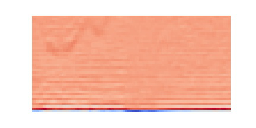

In [0]:
# mfcc spectrogram
image.load_img(val_path/'mfcc/MEL_dia0_utt10_negative_FEA_mfcc.jpg', target_size=(128, 256))

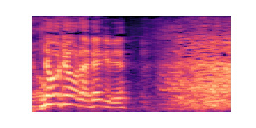

In [0]:
# mel spectgroam
image.load_img(val_path/'mel/MEL_dia0_utt10_negative_FEA_mel.jpg', target_size=(128, 256))


###### /255. to normalize the img data it help us to converge faster and prevents gradient vanishing/exploding



In [0]:
# validation data
val_emotion = []
val_mfcc = []
val_mel = []
val_rms = []
val_text= []

for key in val_features.keys():
  val_emotion.append(val_features[key]['emotion'])
  val_mfcc.append(image.img_to_array(image.load_img(val_path+'mfcc/'+val_features[key]['mfcc'], target_size=(128, 256)))/255.)
  val_mel.append(image.img_to_array(image.load_img(val_path+'mel/'+val_features[key]['mel'], target_size=(128, 256)))/255.)
  val_rms.append(val_features[key]['rms'])
  val_text.append(val_features[key]['text'])  

In [0]:
# train data
train_emotion = []
train_mfcc = []
train_mel = []
train_rms = []
train_text= []

for key in train_features.keys():
  train_emotion.append(train_features[key]['emotion'])
  train_mfcc.append(image.img_to_array(image.load_img(train_path+'mfcc/'+train_features[key]['mfcc'], target_size=(128, 256)))/255.)
  train_mel.append(image.img_to_array(image.load_img(train_path+'mel/'+train_features[key]['mel'], target_size=(128, 256)))/255.)
  train_rms.append(train_features[key]['rms'])
  train_text.append(train_features[key]['text'])
  
  

In [0]:
# validate the lengths
print(len(val_emotion), len(val_mfcc), len(val_mel), len(val_rms), len(val_text))
print(len(train_emotion), len(train_mfcc), len(train_mel), len(train_rms), len(train_text))

830 830 830 830 830
2548 2548 2548 2548 2548


In [0]:
# above seems fair

In [0]:
# rms archive
val_rms_ = val_rms
train_rms_ = train_rms

In [0]:
# see whether shape of the rms energy is uniform or not
val_rms = np.asarray(val_rms)
train_rms = np.asarray(train_rms)
print(val_rms.shape, train_rms.shape)

(830,) (2548,)


###### before processing the text data we have another (level = severe+1 hahaha kidding) problem to tackle which is non-uniform shape of rms energy, we can address this problem by introducing:
-  padding
- clipping

###### we will do the both (that too manually) lets go

In [0]:
val_rms_pad = np.zeros((val_rms.shape[0], 256), dtype=np.float32)
train_rms_pad = np.zeros((train_rms.shape[0], 256), dtype=np.float32)


In [0]:
for i in range(val_rms.shape[0]):
  if val_rms[i].shape[0]>256:
    val_rms_pad[i] = val_rms[i][:256]
  else:
    val_rms_pad[i][:val_rms[i].shape[0]] = val_rms[i]
    
for i in range(train_rms.shape[0]):
  if train_rms[i].shape[0]>256:
    train_rms_pad[i] = train_rms[i][:256]
  else:
    train_rms_pad[i][:train_rms[i].shape[0]] = train_rms[i]

In [0]:
print(val_rms_pad.shape, train_rms_pad.shape)

(830, 256) (2548, 256)


In [0]:
# bingo we're ready for text processing

#### text preprocessing

In [0]:
!unzip /content/drive/My\ Drive/glove6b50dtxt

Archive:  /content/drive/My Drive/glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [0]:
import re
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros

In [0]:
def preprocess_text(sen):
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
clean_val_text = [preprocess_text(each) for each in val_text]
clean_train_text = [preprocess_text(each)for each in train_text]

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(clean_train_text)

In [0]:
val_seq = tokenizer.texts_to_sequences(clean_val_text)
train_seq = tokenizer.texts_to_sequences(clean_train_text)

In [0]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200

In [0]:
val_seq = pad_sequences(val_seq, padding='post', maxlen=maxlen)
train_seq = pad_sequences(train_seq, padding='post', maxlen=maxlen)

In [0]:
# the auspecious time has arrived to get in touch with beautiful word embeddings 

In [0]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.50d.txt', encoding="utf8")


In [0]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
embedding_matrix.shape

(2310, 50)

##### Bingo data is ready to train the model

## 3.3 Model Architecture

##### The Mutlimodal Architecture is inspired by the another Multimodal architecture for Fake News Detection proposed in [2]

In [0]:
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *

In [0]:
from keras.utils import plot_model

### 3.3.1: CNN for Mel Spectrogram
- The authors of the [1] have suggessted to use bigger filter size for mel spectrogram which seems reasonable after seeing the pattern in the mel spectrogram

In [0]:
'''largers filter size will capture the large region from the image'''

def create_mel_cnn(input_shape=(128, 256, 3), num_classes=5):
  
  inp = Input(shape=input_shape, name='mel_cnn_input')
  
  x = Conv2D(filters=64, kernel_size=(5, 5), activation='relu', name='mel_cnn_conv2d_1')(inp)
  x = Conv2D(filters=50, kernel_size=(7, 7), activation='relu', name='mel_cnn_conv2d_2')(x)
  x = Conv2D(filters=32, kernel_size=(11, 11), activation='relu', name='mel_cnn_conv2d_3')(x)
  x = Conv2D(filters=32, kernel_size=(17, 17), activation='relu', name='mel_cnn_conv2d_4')(x)
  x = Conv2D(filters=28, kernel_size=(24, 32), activation='relu', name='mel_cnn_conv2d_5')(x)
  x = Conv2D(filters=24, kernel_size=(30, 40), activation='relu', name='mel_cnn_conv2d_6')(x)
  x = GlobalAveragePooling2D(name='mel_cnn_gap_1')(x)
  x = Dropout(rate=0.20, name='mel_cnn_dropout_1')(x)
  x = Dense(units=32, activation='relu', name='mel_cnn_dense_1')(x)
  x = Dropout(rate=0.20, name='mel_cnn_dropout_2')(x)
  out = Dense(units=16, activation='linear', name='mel_cnn_output')(x)
  
  # Keras Functional API
  mel = Model(inputs=inp, outputs=out)
  
  return mel
  

In [0]:
# mel = create_mel_cnn()

In [0]:
# mel.summary()

### 3.3.2 CNN for MFCC Spectrogram

In [0]:
# !pip install keras_efficientnets

In [0]:
#from keras_efficientnets import EfficientNetB4, EfficientNetB5, EfficientNetB0
from keras.applications import DenseNet121


In [0]:
'''the purpose of the choosing densenet architecture over other arch which could possibly perform
better is, we can go much deeper without exploding the params'''

def create_mfcc_cnn(input_shape=(128, 256, 3), num_classes=5):
  
  dense = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet', classes=num_classes)
  
  # add few layers so that we can get the desired features
  layer_1 = GlobalAveragePooling2D(name='mfcc_cnn_gap_1')(dense.output)
  layer_2 = Dense(units=128, activation='relu', name='mfcc_cnn_dense_1')(layer_1)
  output = Dense(units=16, activation='linear', name='mfcc_cnn_dense_2')(layer_2)
  
  # Keras Functional API
  mfcc = Model(inputs=dense.input, outputs=output)
  
  return mfcc

In [0]:
mfcc = create_mfcc_cnn()

In [0]:
# mfcc.summary()

### 3.3.3 Deep Neural Network for RMS Energy

In [0]:
'''RMS enery is rank-1 tensor of size 128'''

def create_mlp(input_shape=(256, )):
  
  inp = Input(shape=input_shape, name='')
  x = Dense(units=256, activation='relu', name='mlp_dense_1')(inp)
  x = Dense(units=128, activation='relu', name='mlp_dense_2' )(x)
  x = Dense(units=64, activation='relu', name='mlp_dense_3')(x)
  x = Dense(units=32, activation='relu', name='mlp_dense_4')(x)
  out = Dense(units=16, activation='linear', name='mlp_dense_5')(x)
  rms = Model(inputs=inp, outputs=out)
  return rms
  

In [0]:
rms = create_mlp()

In [0]:
rms.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128)               0         
_________________________________________________________________
mlp_dense_1 (Dense)          (None, 256)               33024     
_________________________________________________________________
mlp_dense_2 (Dense)          (None, 128)               32896     
_________________________________________________________________
mlp_dense_3 (Dense)          (None, 64)                8256      
_________________________________________________________________
mlp_dense_4 (Dense)          (None, 32)                2080      
_________________________________________________________________
mlp_dense_5 (Dense)          (None, 16)                528       
Total params: 76,784
Trainable params: 76,784
Non-trainable params: 0
______________________________________________________

In [0]:
# plot_model(rms, to_file='rms.png', show_shapes=True, expand_nested=True)

### 3.4 LSTM for Textual Feature (Text of the Speech)

In [0]:
'''LSTM Model : we will feed text data to this LSTM architecture and get a rank-1 tensor of size 16'''

def create_lstm(max_len=maxlen):
  
  inp = Input(shape=(maxlen,), name='lstm_input')
  embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False, name='lstm_embedding_layer')(inp)
  LSTM_Layer_1 = LSTM(128, name='lstm_layer_1')(embedding_layer)
  x = Dense(64, activation='linear', name='lstm_dense_layer_1')(LSTM_Layer_1)
  out = Dense(16, activation='linear', name='lstm_dense_layer_2')(x)
  
  lstm = Model(inputs=inp, outputs=out)
  
  return lstm

  
  

In [0]:
lstm = create_lstm()

In [0]:
lstm.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      (None, 500)               0         
_________________________________________________________________
lstm_embedding_layer (Embedd (None, 500, 100)          500000    
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 128)               117248    
_________________________________________________________________
lstm_dense_layer_1 (Dense)   (None, 64)                8256      
_________________________________________________________________
lstm_dense_layer_2 (Dense)   (None, 16)                1040      
Total params: 626,544
Trainable params: 126,544
Non-trainable params: 500,000
_________________________________________________________________


### 3.5 Combining the above models to design a multimodal architecutre 

In [0]:
# creating the models, each model will give a rank-1 tensor of size 16 corresponding the modality we will feed it.
mel = create_mel_cnn()
mfcc = create_mfcc_cnn()
mlp = create_mlp()
lstm = create_lstm()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



29089792/29084464 [==============================] - 0s 0us/step


In [0]:
def create_multimodal(mel, mfcc, mlp, lstm, num_classes=5):
  
  # concatenate the output of the each model this process is also called fusion
  fusion = concatenate([mel.output, mfcc.output, mlp.output, lstm.output], name = 'fusion_layer')
  
  x = Dense(units=32, activation='relu', name='mm_dense_1')(fusion)
  x = Dense(units=16, activation='relu', name='mm_dense_2')(x)
 
  output = Dense(units=num_classes, activation='softmax', name='final_output_layer')(x)
  
  model = Model(inputs=[mel.input, mfcc.input,  mlp.input, lstm.input], outputs=output)
  
  return model
  

In [0]:
model = create_multimodal(mel, mfcc, mlp, lstm)

In [0]:
# model.summary()

## 3.4. Training of the Model

In [0]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
# we need to shuffle the data before feeding it to the model, beacuse currently is sequential manner 
#  it means all the data that belongs to class is togehter, shuffling will help us to converge faster
val_mel, val_mfcc, val_rms, val_seq, val_emotion = shuffle(val_mel, val_mfcc, val_rms, val_seq, val_emotion)
train_mel, train_mfcc, train_rms, train_seq, train_emotion = shuffle(train_mel, train_mfcc, train_rms, train_seq, train_emotion)

In [0]:
lb = LabelEncoder()

In [0]:
val_labels = lb.fit_transform(val_emotion)
train_labels = lb.transform(train_emotion)

In [0]:
y_test = to_categorical(val_labels, num_classes=5)
y_train = to_categorical(train_labels, num_classes=5)

In [0]:
y_train[:4]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

###### create the callbacks

In [0]:
mcp = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=1)

###### All set to rock

In [0]:
# order of the input of the multimodal architecture ! do not uncomment these lines
# inputs=[mel.input, mfcc.input,  mlp.input, lstm.input], outputs=output)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
hist = model.fit([train_mel, train_mfcc, train_rms_pad, train_seq], y_train, validation_data=([val_mel, val_mfcc, val_rms_pad, val_seq], y_test), epochs=20, batch_size=8, callbacks=[mcp, es])

Train on 2548 samples, validate on 830 samples
Epoch 1/20
2548/2548 [==============================] - 327s 128ms/step - loss: 14.5366 - acc: 0.0981 - val_loss: 15.5744 - val_acc: 0.0337

Epoch 00001: val_acc did not improve from 0.03373
Epoch 2/20
2548/2548 [==============================] - 327s 128ms/step - loss: 14.4987 - acc: 0.1005 - val_loss: 15.5744 - val_acc: 0.0337

Epoch 00002: val_acc did not improve from 0.03373


(2548,)

#### Model Evaluation

In [0]:
from google.colab import files
uploaded = files.upload()

Saving plot_confusion_matrix.py to plot_confusion_matrix.py


In [0]:
from plot_confusion_matrix import plot_confusion_matrix

In [0]:
pred_train = np.argmax(model.predict([train_mel, train_mfcc, train_rms_pad, train_seq]), axis=1)

In [0]:
pred_val = np.argmax(model.predict([val_mel, val_mfcc, val_rms_pad, val_seq]), axis=1)

In [0]:
plt.style.use('seaborn')

Confusion matrix, without normalization


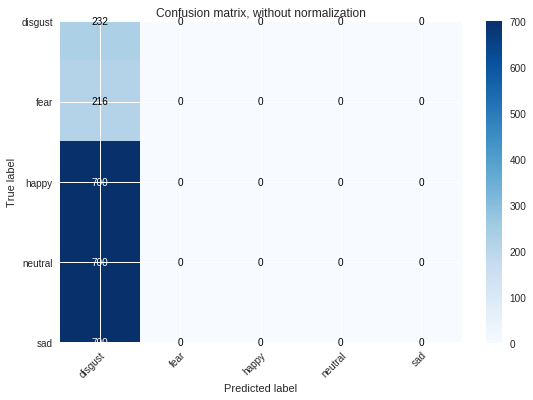

In [0]:
plot_confusion_matrix(y_true=train_labels, y_pred=pred_train, classes=lb.classes_, normalize=False);

Confusion matrix, without normalization


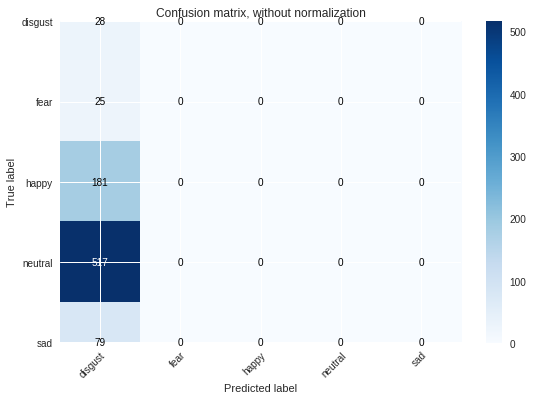

In [0]:
plot_confusion_matrix(y_true=val_labels, y_pred=pred_val, classes=lb.classes_, normalize=False);

In [0]:
val_labels.shape

(830,)

## 3.5. Arhichitecture Visualization

In [0]:
from keras.utils import plot_model

In [0]:
# plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96)

# **4. Speech Emotion Recognition using Praat Features (mainly prosodic features)**

###### Emotion of the speech sound also depends upon prosodic pitch, intensity, tempo etc. Here we're trying to learn the pattern in prosodic features of different emotion speech.



### Using praat-parselmouth: A python interface to praat

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving plot_confusion_matrix.py to plot_confusion_matrix.py


In [0]:
# !unzip drive/My\ Drive/emotion

In [4]:
# # install the dependency
!pip install praat-parselmouth


     |████████████████████████████████| 9.0MB 6.4MB/s 


In [0]:
# import the dependencies
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [0]:
sns.set()

In [0]:
snd = parselmouth.Sound("meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav")

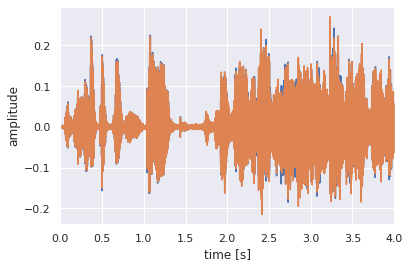

In [13]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

In [0]:
mfcc = snd.to_mfcc().to_array()

In [15]:
mfcc.shape[0]*mfcc.shape[1]

10361

## 4.1 Feature Extraction

###### extracting diff parsel mouth features

In [0]:
def extract_mfcc(sound):
  mfcc = sound.to_mfcc().to_array()
  mfcc = mfcc.flatten()
  return mfcc
  
def intensity(sound):
  intensity = sound.to_insity()

In [0]:
def load_data(subdir):
  x = []
  y = []
 
  classes = os.listdir(subdir)
  for cls in classes:
    
    count = 0
    files = np.array(os.listdir(subdir+'/'+cls))
    #downsmpling
    if len(files) > 700:
      files = files[np.random.permutation(700)]
    for file in files:
      sound = parselmouth.Sound(subdir+'/'+cls+'/'+file)
      mfcc = extract_mfcc(sound)
      x.append(mfcc)
      y.append(cls)
      
      if count%500==0:
        print("{}/{} of class ".format(count, len(files))+cls+" have been processed")
      count += 1
        
  return x, y
  

In [0]:
# extract features for validation data
test_mfcc, test_labels = load_data('meld/val')

0/181 of class happy have been processed
0/517 of class neutral have been processed
500/517 of class neutral have been processed
0/28 of class disgust have been processed
0/25 of class fear have been processed
0/79 of class sad have been processed


In [0]:
# extract features for training data
train_mfcc, train_labels = load_data('meld/train')

0/700 of class happy have been processed
500/700 of class happy have been processed
0/700 of class neutral have been processed
500/700 of class neutral have been processed
0/232 of class disgust have been processed
0/216 of class fear have been processed
0/700 of class sad have been processed
500/700 of class sad have been processed


In [0]:
train_mfcc_shapes = [each.shape[0] for each in train_mfcc]
test_mfcc_shapes = [each.shape[0] for each in test_mfcc]

In [0]:
# the shape of the features might not be uniform, we have to make it uniform in order to train a classifier
# get the maximum, mean and minimum size from the both (train and test data)
print(np.max(train_mfcc_shapes), np.mean(train_mfcc_shapes), np.min(train_mfcc_shapes))
print(np.max(test_mfcc_shapes), np.mean(test_mfcc_shapes), np.min(test_mfcc_shapes))


611117 8931.734693877552 91
792831 9081.079518072289 260


In [0]:
# we will take only first 10K values (which is close to means shape), eventually have to compromise to lose the informration
train = np.zeros((len(train_mfcc), 50000))
test = np.zeros((len(test_mfcc), 50000))

In [0]:
for i in range(len(train_mfcc)):
  if train_mfcc[i].shape[0] > train.shape[1]:
    train[i] = train_mfcc[i][:train.shape[1]]
  else:
    train[i][:train_mfcc[i].shape[0]] = train_mfcc[i]

for i in range(len(test_mfcc)):
  if test_mfcc[i].shape[0] > test.shape[1]:
    test[i] = test_mfcc[i][:test.shape[1]]
  else:
    test[i][:test_mfcc[i].shape[0]] = test_mfcc[i]

In [0]:
print(train.shape, test.shape)

(2548, 50000) (830, 50000)


##4.2 Classification Model 

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

#### preprocessing

In [0]:
lb = LabelEncoder()

In [0]:
y_train = lb.fit_transform(train_labels)
y_test = lb.transform(test_labels)

In [0]:
x_train, y_train = shuffle(train, y_train)
x_test, y_test = shuffle(test, y_test)

#### creating and training the MLP classifier

In [0]:
mfcc = MLPClassifier()

In [0]:
mfcc.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
train_pred = mfcc.predict(x_train)
test_pred = mfcc.predict(x_test)

In [0]:
print('test acc :{}'.format(accuracy_score(y_true=y_train, y_pred=train_pred)))

test acc :0.6216640502354788


In [0]:
print('test acc :{}'.format(accuracy_score(y_true=y_test, y_pred=test_pred)))

test acc :0.12771084337349398


In [0]:
from plot_confusion_matrix import plot_confusion_matrix

Confusion matrix, without normalization


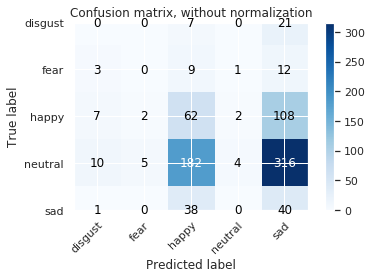

In [0]:
plot_confusion_matrix(y_test, test_pred, lb.classes_)

# .py function and README.txt file

In [20]:
from google.colab import files
uploaded = files.upload()

Saving README.txt to README.txt


In [0]:
combined = [test_files, test_pred]

with open("README.txt", "w") as file:
    for x in zip(*combined):
        file.write("{0},{1}\n".format(*x))

In [0]:
d= {}
with open('README.txt', '+r') as f:
  a = f.readlines()
  

In [0]:
with open('README.txt', '+r') as f:
  
  data = f.readlines()
  
  predicted = dict([(each.split(', ')[0],each.split(', ')[1].split('\n')[0]) for each in data ])

In [0]:
import os
import pickle
def accuracy(path='meld/val'):
  with open('README.txt', '+r') as f:
  
    data = f.readlines()
  
  predictions = dict([(each.split(', ')[0],each.split(', ')[1].split('\n')[0]) for each in data ])
  
  correct_prediction=0
  for cls in os.listdir(path):
    for file in os.listdir(path+'/'+cls):
      if predictions[file]==cls:
        correct_prediction += 1
  return correct_prediction/len(predictions)

In [52]:
accuracy()

0.6204819277108434

# Summary and Discussion

Speech Emotion Recognition has always been a challeging task. In this Notebook I've tried to classsify the speech emotion using multiple features of the speech (ie: Spectral Features, Porsodic Features, Textual Features).
Model and its given bellow:

##### Model_Name &emsp;&emsp;&emsp;&emsp; Feature &emsp;&emsp;&emsp;&emsp;  Accuracy

        SVM     Spectral Feautres       ~62-65%
        
        MLP         ''                    ''
        
        CNN         ''                    ''
        
        BERT        Text                ~40-45%
        
        Multimodal   Spectral+Text       NA
        
        MLP          Prosodic           ~60-65%
        
 The multimodal architecture did not train well possible due the data discrepancy likely caused by the features extraction approach and use of multiple notebooks instead of gathering the data using single notebook. Why I am saying MM model did not perform well due to data discrepancy beacause I've trained the MM architecture more than once by tuning the hyper-parameters but got the same results every time. I'm trying to fix the data discrepancy problem that I'm facing right now in MM training.
 
People at MIDAS@IIITD have achived state-of-the-art result for different problems using Multimodal approach(ie: SpotFake, MM for social media popularity prediciton etc) which makes me optimistic(considering the nature of the problem) 00000000
hat the proposed Multimodal model has potential to achieve state-of-the-art results in recognizing speech emotion (including prosodic features Modality).
        


# **References**

[1] Suraj Tripathi et al. *Deep Learning based Emotion Recognition System Using Speech Features and Transcriptions*

[2] Rajiv Ratn Shah et al. *SpotFake: A Multi-modal Framework for Fake News Detection*

[3] Librosa Official Documentation *https://librosa.github.io/librosa/index.html*

[4] Praselmouth official Documentation
*https://parselmouth.readthedocs.io/en/stable/index.html*




